### Figure S10: Heat Budget

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cf_xarray
import cartopy.crs as ccrs
import cmocean as cm
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
from dask.distributed import Client
import matplotlib.path as mpath
import scipy as sp
import scipy.interpolate
import scipy.ndimage
import scipy.io
import scipy.stats
import pandas as pd
from pandas import DataFrame
import cartopy.feature as cft
from metpy.interpolate import cross_section
from pathlib import Path
import xgcm
from pyproj import Proj, transform
import pyproj
from datetime import datetime, timedelta
from xhistogram.xarray import histogram
import matplotlib.ticker as mticker
import intake

In [2]:
from dask.distributed import Client

client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37667,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46673,Total threads: 1
Dashboard: /proxy/39725/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:38551,


In [3]:
cat = intake.cat.access_nri
experiment = '01deg_jra55v140_iaf_cycle4' # the RYF90-91 experiment

exp_ds = cat[experiment]
exp_ds

,unique
filename,127845
path,131730
file_id,32
frequency,5
start_date,4324
end_date,4324
variable,335
variable_long_name,257
variable_standard_name,37
variable_cell_methods,6


In [4]:
grid_vars = ['xt_ocean','yt_ocean','st_edges_ocean','st_ocean']
coord_ds = exp_ds.search(
    variable=grid_vars, 
    file_id='ocean.1mon.nv:2.st_edges_ocean:76.st_ocean:75.xt_ocean:3600.yt_ocean:2700',
    frequency='1mon'
).to_dask(
    xarray_open_kwargs={
        'chunks' : "auto",
    }
)
xt_ocean = coord_ds['xt_ocean'].sel(xt_ocean=slice(-150,-50))
yt_ocean = coord_ds['yt_ocean'].sel(yt_ocean=slice(-80,-60))
st_ocean = coord_ds['st_ocean']

st_edges_ocean = coord_ds['st_edges_ocean']

In [5]:
aslat = slice(-75.5,-70)
aslon = slice(-120,-95)
latslice = slice(-76,-64.99) # make sure t and u cells have same lengths
lonslice = slice(-150,-70)
# Load data from perturbation experiments
pert_path = '/g/data/jk72/or6852/01deg_jra55_ryf_amundsen_perturbation_zonal200205/' # zonal
pert_path2 = '/g/data/jk72/or6852/01deg_jra55_ryf_amundsen_perturbation_both200205/' # both
cont_path = '/g/data/jk72/or6852/01deg_jra55_ryf_amundsen_perturbation_control/'

g=[]
g2 = []
q=[]
#q2 = []
for i in range(1000,1020):
    g.append(pert_path+'output'+str(i) + '/ocean/' + 'ocean_month.nc')
    g2.append(pert_path2+'output'+str(i) + '/ocean/' + 'ocean_month.nc')
    q.append(cont_path+'output'+str(i) + '/ocean/' + 'ocean_month.nc')

taux_pert = xr.open_mfdataset(g,combine='by_coords',chunks={'time': 1},decode_times = True)['tau_x'].sel(yu_ocean = slice(-77,-62)).sel(xu_ocean = slice(-150,-64))
taux_pert2 = xr.open_mfdataset(g2,combine='by_coords',chunks={'time': 1},decode_times = True)['tau_x'].sel(yu_ocean = slice(-77,-62)).sel(xu_ocean = slice(-150,-64))
taux_cont = xr.open_mfdataset(q,combine='by_coords',chunks={'time': 1},decode_times = True)['tau_x'].sel(yu_ocean = slice(-77,-62)).sel(xu_ocean = slice(-150,-64))

tauy_pert = xr.open_mfdataset(g,combine='by_coords',chunks={'time': 1},decode_times = True)['tau_y'].sel(yu_ocean = slice(-77,-62)).sel(xu_ocean = slice(-150,-64))
tauy_pert2 = xr.open_mfdataset(g2,combine='by_coords',chunks={'time': 1},decode_times = True)['tau_y'].sel(yu_ocean = slice(-77,-62)).sel(xu_ocean = slice(-150,-64))
tauy_cont = xr.open_mfdataset(q,combine='by_coords',chunks={'time': 1},decode_times = True)['tau_y'].sel(yu_ocean = slice(-77,-62)).sel(xu_ocean = slice(-150,-64))

temp_pert = xr.open_mfdataset(g,combine='by_coords',chunks={'time': 1},decode_times = True)['temp'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load() - 273.15
temp_pert2 = xr.open_mfdataset(g2,combine='by_coords',chunks={'time': 1},decode_times = True)['temp'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load() - 273.15
temp_cont = xr.open_mfdataset(q,combine='by_coords',chunks={'time': 1},decode_times = True)['temp'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load() - 273.15

salt_pert = xr.open_mfdataset(g,combine='by_coords',chunks={'time': 1},decode_times = True)['salt'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load()
salt_pert2 = xr.open_mfdataset(g2,combine='by_coords',chunks={'time': 1},decode_times = True)['salt'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load()
salt_cont = xr.open_mfdataset(q,combine='by_coords',chunks={'time': 1},decode_times = True)['salt'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load()


In [6]:
# Load grid variables: ht, area_t
ht = xr.open_dataset(pert_path+'output1000/ocean/ocean_grid.nc')['ht'].sel(yt_ocean = latslice).sel(xt_ocean = lonslice)
hu = xr.open_dataset(pert_path+'output1000/ocean/ocean_grid.nc')['hu'].sel(yu_ocean = latslice).sel(xu_ocean = lonslice)
area_t = xr.open_dataset(pert_path+'output1000/ocean/ocean_grid.nc')['area_t'].sel(yt_ocean = latslice).sel(xt_ocean = lonslice).fillna(0)
area_u = xr.open_dataset(pert_path+'output1000/ocean/ocean_grid.nc')['area_u'].sel(yu_ocean = latslice).sel(xu_ocean = lonslice).fillna(0)

In [7]:
# Calculate layer thickness
# Import edges of st_ocean and add lat/lon dimensions:
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean': ht.yt_ocean, 'xt_ocean': ht.xt_ocean}, axis=[1,2])

# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = temp_pert.st_ocean
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean': 'st_ocean'}))
thickness = thickness.fillna(0)

In [8]:
# Calculate layer thickness on u cells
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean': hu.yu_ocean, 'xu_ocean': hu.xu_ocean}, axis=[1,2])

# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness_u = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = temp_pert.st_ocean
thickness_u['st_edges_ocean'] = st_ocean.values
thickness_u = thickness_u.rename(({'st_edges_ocean': 'st_ocean'}))
thickness_u = thickness_u.fillna(0)

In [9]:
above1000 = ht.where(ht>=1000,1) # set all values smaller than 1000 to 1
above1000_tcells = above1000.where(above1000 < 1000) # remove all values bigger than 1000
above1000_tcells = xr.where(((above1000_tcells.xt_ocean<-111) & (above1000_tcells.yt_ocean<-72.6)),np.nan,above1000_tcells) # remove southwest corner that is dynamically part of the Dotson-Getz trough controlled area

### Load heat budget terms

In [10]:
# load terms
h=[]
h2 = []
h3 = []
for i in range(1000,1020):
    h.append(pert_path+'output'+str(i) + '/ocean/' + 'ocean_heat.nc')
    h2.append(pert_path2+'output'+str(i) + '/ocean/' + 'ocean_heat.nc')
    h3.append(cont_path+'output'+str(i) + '/ocean/' + 'ocean_heat.nc')

temp_ten = xr.open_mfdataset(h,combine='by_coords',chunks={'time': 1},decode_times = True)['temp_tendency'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load()
temp_adv = xr.open_mfdataset(h,combine='by_coords',chunks={'time': 1},decode_times = True)['temp_advection'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load()
temp_mix = (xr.open_mfdataset(h,combine='by_coords',chunks={'time': 1},decode_times = True)['temp_vdiffuse_diff_cbt'].sel(yt_ocean = aslat).sel(xt_ocean = aslon)+ xr.open_mfdataset(h,combine='by_coords',chunks={'time': 1},decode_times = True)['temp_nonlocal_KPP'].sel(yt_ocean = aslat).sel(xt_ocean = aslon)).load()

temp_submeso = xr.open_mfdataset(h,combine='by_coords',chunks={'time': 1},decode_times = True)['temp_submeso'].sel(yt_ocean = aslat).sel(xt_ocean = aslon)
temp_surf = xr.open_mfdataset(h,combine='by_coords',chunks={'time': 1},decode_times = True)['sw_heat'].sel(yt_ocean = aslat).sel(xt_ocean = aslon)+xr.open_mfdataset(h,combine='by_coords',chunks={'time': 1},decode_times = True)['temp_vdiffuse_sbc'].sel(yt_ocean = aslat).sel(xt_ocean = aslon)+xr.open_mfdataset(h,combine='by_coords',chunks={'time': 1},decode_times = True)['frazil_3d'].sel(yt_ocean = aslat).sel(xt_ocean = aslon)+xr.open_mfdataset(h,combine='by_coords',chunks={'time': 1},decode_times = True)['temp_rivermix'].sel(yt_ocean = aslat).sel(xt_ocean = aslon)

temp_ten2 = xr.open_mfdataset(h2,combine='by_coords',chunks={'time': 1},decode_times = True)['temp_tendency'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load()
temp_adv2 = xr.open_mfdataset(h2,combine='by_coords',chunks={'time': 1},decode_times = True)['temp_advection'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load()
temp_mix2 = (xr.open_mfdataset(h2,combine='by_coords',chunks={'time': 1},decode_times = True)['temp_vdiffuse_diff_cbt'].sel(yt_ocean = aslat).sel(xt_ocean = aslon)+ xr.open_mfdataset(h2,combine='by_coords',chunks={'time': 1},decode_times = True)['temp_nonlocal_KPP'].sel(yt_ocean = aslat).sel(xt_ocean = aslon)).load()

temp_tenc = xr.open_mfdataset(h3,combine='by_coords',chunks={'time': 1},decode_times = True)['temp_tendency'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load()
temp_advc = xr.open_mfdataset(h3,combine='by_coords',chunks={'time': 1},decode_times = True)['temp_advection'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load()
temp_mixc = (xr.open_mfdataset(h3,combine='by_coords',chunks={'time': 1},decode_times = True)['temp_vdiffuse_diff_cbt'].sel(yt_ocean = aslat).sel(xt_ocean = aslon)+ xr.open_mfdataset(h3,combine='by_coords',chunks={'time': 1},decode_times = True)['temp_nonlocal_KPP'].sel(yt_ocean = aslat).sel(xt_ocean = aslon)).load()


In [12]:
# Calculate anomalies:
# Zonal - control
temp_ten_ano = temp_ten-temp_tenc
temp_adv_ano = temp_adv-temp_advc
temp_mix_ano = temp_mix-temp_mixc
# Both - control
temp_ten_ano2 = temp_ten2-temp_tenc
temp_adv_ano2 = temp_adv2-temp_advc
temp_mix_ano2 = temp_mix2-temp_mixc


### Load sea ice terms:

In [17]:
import glob
g3=[]
g4 = []
q3=[]
q4 = []
for i in range(1000,1020):
    g3.append(glob.glob(pert_path+'output'+str(i) + '/ice/OUTPUT/' + '*.nc')[:])
    g4.append(glob.glob(pert_path2+'output'+str(i) + '/ice/OUTPUT/' + '*.nc')[:])
    q3.append(glob.glob(cont_path+'output'+str(i) + '/ice/OUTPUT/' + '*.nc')[:])
from itertools import chain
g3 = list(chain.from_iterable(g3))
g4 = list(chain.from_iterable(g4))
q3 = list(chain.from_iterable(q3))


In [18]:
# sea ice thickness
hi_c = xr.open_mfdataset(q3,combine='by_coords',chunks={'time': 1}, decode_coords = False,decode_times = True)['hi_m'].sel(nj=slice(133,263)).sel(ni=slice(1600,1850))#.sel(time=slice(start,end))
hi_c.coords['ni'] = temp_cont.sel(xt_ocean = slice(-120,-95)).sel(yt_ocean = slice(-75.5,-70))['xt_ocean'].values
hi_c.coords['nj'] = temp_cont.sel(xt_ocean = slice(-120,-95)).sel(yt_ocean = slice(-75.5,-70))['yt_ocean'].values
hi_c.coords['time'] = temp_cont.time
hi_c = hi_c.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

hi_p = xr.open_mfdataset(g3,combine='by_coords',chunks={'time': 1}, decode_coords = False,decode_times = True)['hi_m'].sel(nj=slice(133,263)).sel(ni=slice(1600,1850))#.sel(time=slice(start,end))
hi_p.coords['ni'] = temp_cont.sel(xt_ocean = slice(-120,-95)).sel(yt_ocean = slice(-75.5,-70))['xt_ocean'].values
hi_p.coords['nj'] = temp_cont.sel(xt_ocean = slice(-120,-95)).sel(yt_ocean = slice(-75.5,-70))['yt_ocean'].values
hi_p.coords['time'] = temp_cont.time
hi_p = hi_p.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

hi_p2 = xr.open_mfdataset(g4,combine='by_coords',chunks={'time': 1}, decode_coords = False,decode_times = True)['hi_m'].sel(nj=slice(133,263)).sel(ni=slice(1600,1850))#.sel(time=slice(start,end))
hi_p2.coords['ni'] = temp_cont.sel(xt_ocean = slice(-120,-95)).sel(yt_ocean = slice(-75.5,-70))['xt_ocean'].values
hi_p2.coords['nj'] = temp_cont.sel(xt_ocean = slice(-120,-95)).sel(yt_ocean = slice(-75.5,-70))['yt_ocean'].values
hi_p2.coords['time'] = temp_cont.time
hi_p2 = hi_p2.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))


In [19]:
# Surface heat flux:
shf_pert = xr.open_mfdataset(g,combine='by_coords',chunks={'time': 1},decode_times = True)['net_sfc_heating'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load()
shf_pert2 = xr.open_mfdataset(g2,combine='by_coords',chunks={'time': 1},decode_times = True)['net_sfc_heating'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load()
shf_cont = xr.open_mfdataset(q,combine='by_coords',chunks={'time': 1},decode_times = True)['net_sfc_heating'].sel(yt_ocean = aslat).sel(xt_ocean = aslon).load()


In [14]:
# Plot parametres: define projection and boundary path, landmask
xt2d = xt_ocean.expand_dims({'yt_ocean':yt_ocean})
yt2d = yt_ocean.expand_dims({'xt_ocean':xt_ocean})

def make_boundary_path(longitudes, latitudes):
    """
    Return a path around boundary to create a sector map, then cut it out given
    longitudes and latitudes.
    """
    boundary_path = np.array([longitudes[-1, :], latitudes[-1, :]])
    boundary_path = np.append(boundary_path, np.array([longitudes[::-1, -1], latitudes[::-1, -1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[1, ::-1],  latitudes[1, ::-1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[:, 1],     latitudes[:, 1]]), axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

# Eastern Amundsen
midlon = -107.5
maxlon = -95
minlon = -120
minlat = -75.609
maxlat = -70.509
midlat = (minlat + maxlat)/2
lons = xt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = yt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)}).T
boundary_path_pibl = make_boundary_path(lons, lats)
extent_pibl = [minlon,maxlon,minlat,maxlat]
projection_pibl = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)


# West Antarctica
midlon = -105
maxlon = -70
minlon = -140
minlat = -76
maxlat = -64
midlat = (minlat + maxlat)/2
lons = xt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = yt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)}).T
boundary_path_wa = make_boundary_path(lons, lats)
extent_wa = [minlon,maxlon,minlat,maxlat]
projection_wa = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

In [15]:
# Define for plotting
land_u = xr.where(np.isnan(hu.rename('land')), 1, np.nan)
land = xr.where(np.isnan(ht.rename('land')), 1, np.nan)
land100 = xr.where(np.isnan(ht.where(ht>100).rename('land')), 1, np.nan)

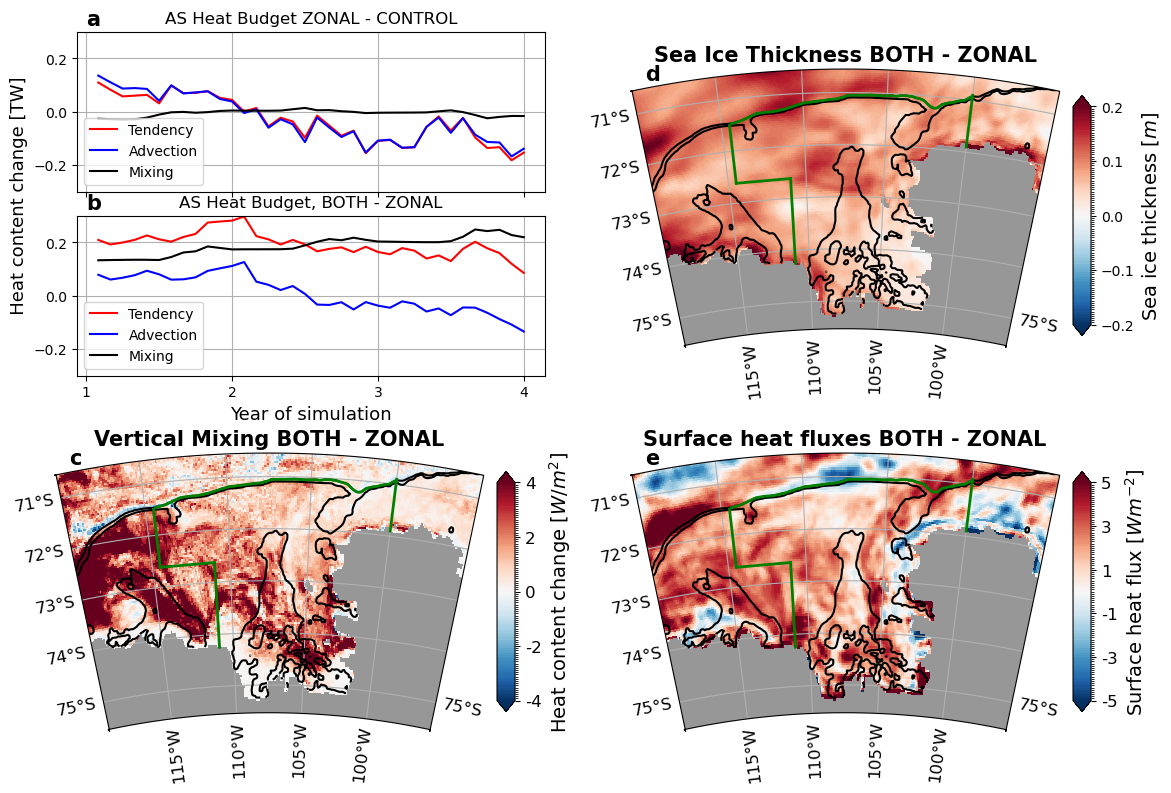

In [20]:
# Supplementary figure: Driving mechanism of meridional winds: AS heat budget, maps of vert mixing anomaly and sea ice thickness? 
d1 = 100
roltime = 25
fig = plt.figure(figsize=(12,8))
ax1 = plt.axes([0.07,0.75,0.39,0.2])
ax1.plot((temp_ten_ano*above1000_tcells*area_t*1e-12).sel(xt_ocean = slice(-114.5,-100)).sel(yt_ocean = slice(-75.6,-70)).sel(st_ocean = slice(d1,1000)).sum({'xt_ocean','yt_ocean','st_ocean'}).chunk(time=-1).rolling(time=roltime,center=True).mean(),color='r',label='Tendency')
ax1.plot((temp_adv_ano*above1000_tcells*area_t*1e-12).sel(xt_ocean = slice(-114.5,-100)).sel(yt_ocean = slice(-75.6,-70)).sel(st_ocean = slice(d1,1000)).sum({'xt_ocean','yt_ocean','st_ocean'}).chunk(time=-1).rolling(time=roltime,center=True).mean(),color='b',label='Advection')
ax1.plot((temp_mix_ano*above1000_tcells*area_t*1e-12).sel(xt_ocean = slice(-114.5,-100)).sel(yt_ocean = slice(-75.6,-70)).sel(st_ocean = slice(d1,1000)).sum({'xt_ocean','yt_ocean','st_ocean'}).chunk(time=-1).rolling(time=roltime,center=True).mean(),color='k',label='Mixing')

ax1.set_title('AS Heat Budget ZONAL - CONTROL')
ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.set_xticks(np.arange(11,50,12),['','','',''])
ax1.set_ylim([-0.3,0.3])
ax1.grid()
ax1.legend(loc = 'lower left')
ax1.text(0.02,1.04,'a',color='k',fontsize=15,fontweight='bold',transform=ax1.transAxes)

ax2 = plt.axes([0.07,0.52,0.39,0.2])
ax2.plot(((temp_ten_ano2-temp_ten_ano)*above1000_tcells*area_t*1e-12).sel(xt_ocean = slice(-114.5,-100)).sel(yt_ocean = slice(-75.6,-70)).sel(st_ocean = slice(d1,1000)).sum({'xt_ocean','yt_ocean','st_ocean'}).chunk(time=-1).rolling(time=roltime,center=True).mean(),color='r',lw=1.5,label='Tendency')
ax2.plot(((temp_adv_ano2-temp_adv_ano)*above1000_tcells*area_t*1e-12).sel(xt_ocean = slice(-114.5,-100)).sel(yt_ocean = slice(-75.6,-70)).sel(st_ocean = slice(d1,1000)).sum({'xt_ocean','yt_ocean','st_ocean'}).chunk(time=-1).rolling(time=roltime,center=True).mean(),color='b',lw=1.5, label='Advection')
ax2.plot(((temp_mix_ano2-temp_mix_ano)*above1000_tcells*area_t*1e-12).sel(xt_ocean = slice(-114.5,-100)).sel(yt_ocean = slice(-75.6,-70)).sel(st_ocean = slice(d1,1000)).sum({'xt_ocean','yt_ocean','st_ocean'}).chunk(time=-1).rolling(time=roltime,center=True).mean(),color='k',lw=1.5, label='Mixing')

ax2.set_title('AS Heat Budget, BOTH - ZONAL')
ax2.set_ylabel('                                   Heat content change [TW]', fontsize=13)
ax2.set_xlabel('Year of simulation', fontsize=13)
ax2.set_xticks(np.arange(11,50,12),['1','2','3','4'])
ax2.set_ylim([-0.3,0.3])
ax2.grid()
ax2.legend()
ax2.text(0.02,1.04,'b',color='k',fontsize=15,fontweight='bold',transform=ax2.transAxes)

# Vert mixing
ax3 = plt.axes([0.05,0.06,0.36,0.35],projection = projection_pibl)
ax3.set_extent(extent_pibl, crs=ccrs.PlateCarree())
gl = ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
ax3.set_boundary(boundary_path_pibl, transform=ccrs.PlateCarree())    
p1 = (temp_mix_ano2-temp_mix_ano).sel(st_ocean = slice(100,1000)).sum('st_ocean')[24:,:,:].mean('time').plot(ax=ax3,
                    x='xt_ocean', y='yt_ocean', levels = np.linspace(-4,4,101), add_colorbar = False, cmap='RdBu_r', extend='both',
                    transform=ccrs.PlateCarree())
p3 = ht.plot.contour(ax=ax3,
                   x='xt_ocean', y='yt_ocean', levels=[600,1000], colors='k',linewidths=1.5, alphas=1,
                   transform=ccrs.PlateCarree())
ht.where(ht>100).fillna(-1).where(np.isnan(ht.where(ht>100))).plot(ax=ax3,levels=[-4,-2,0,2],cmap='Greys_r',add_colorbar = False,transform=ccrs.PlateCarree())        
ax3.set_title('')
# green box around the AS area
ax3.plot([-114.5,-114.5],[-71.5,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
ax3.plot([-114.5,-111],[-72.62,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
ax3.plot([-111,-111],[-72.62,-74.25],color='g',lw=2,transform=ccrs.PlateCarree())
ax3.plot([-100,-100],[-71.9,-70.9],color='g',lw=2,transform=ccrs.PlateCarree())
ht.sel(xt_ocean = slice(-114.5,-100)).sel(yt_ocean = slice(-71.5,-70.8)).plot.contour(ax=ax3,
                   x='xt_ocean', y='yt_ocean', levels=[1000], colors='g',linewidths=2,
                   transform=ccrs.PlateCarree())
# indicate section
#ax3.plot(slo,sla,color='y', ls='none', marker='o', markersize=2, transform=ccrs.PlateCarree())


ax3.text(-119,-70.4,'c',color='k',fontsize=15,fontweight='bold',transform=ccrs.PlateCarree())
ax3.text(-107.5,-70.4,'Vertical Mixing BOTH - ZONAL',horizontalalignment='center', color='k',fontsize=15,fontweight = 'bold',transform=ccrs.PlateCarree())

axin1 = plt.axes([0.42,0.1,0.015,0.3])
cb=plt.colorbar(p1,cax=axin1,ticks=np.arange(-4,6,2),orientation='vertical',aspect = 50)
cb.set_label('Heat content change [$W/m^2$]',fontsize=14)
cb.set_ticks(np.arange(-4,6,2), labels=np.round(np.arange(-4,6,2),0),fontsize=12)


# sea ice thickness
ax4 = plt.axes([0.53,0.54,0.36,0.35],projection = projection_pibl)
ax4.set_extent(extent_pibl, crs=ccrs.PlateCarree())
gl = ax4.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
ax4.set_boundary(boundary_path_pibl, transform=ccrs.PlateCarree())    
p1 = (hi_p2-hi_p)[24:,:,:].mean('time').plot(ax=ax4,
                    x='xt_ocean', y='yt_ocean', levels = np.linspace(-.2,.2,101), add_colorbar = False, cmap='RdBu_r', extend='both',
                    transform=ccrs.PlateCarree())
p3 = ht.plot.contour(ax=ax4,
                   x='xt_ocean', y='yt_ocean', levels=[600,1000], colors='k',linewidths=1.5, alphas=1,
                   transform=ccrs.PlateCarree())
ht.fillna(-1).where(np.isnan(ht)).plot(ax=ax4,levels=[-4,-2,0,2],cmap='Greys_r',add_colorbar = False,transform=ccrs.PlateCarree())        
ax4.set_title('')
# green box around the AS area
ax4.plot([-114.5,-114.5],[-71.5,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
ax4.plot([-114.5,-111],[-72.62,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
ax4.plot([-111,-111],[-72.62,-74.25],color='g',lw=2,transform=ccrs.PlateCarree())
ax4.plot([-100,-100],[-71.9,-70.9],color='g',lw=2,transform=ccrs.PlateCarree())
ht.sel(xt_ocean = slice(-114.5,-100)).sel(yt_ocean = slice(-71.5,-70.8)).plot.contour(ax=ax4,
                   x='xt_ocean', y='yt_ocean', levels=[1000], colors='g',linewidths=2,
                   transform=ccrs.PlateCarree())

ax4.text(-119,-70.4,'d',color='k',fontsize=15,fontweight='bold',transform=ccrs.PlateCarree())
ax4.text(-107.5,-70.4,'Sea Ice Thickness BOTH - ZONAL',horizontalalignment='center', color='k',fontsize=15,fontweight = 'bold',transform=ccrs.PlateCarree())

axin2 = plt.axes([0.9,0.57,0.015,0.3])
cb=plt.colorbar(p1,cax=axin2,ticks=np.arange(-.2,.3,.1),orientation='vertical',aspect = 50)
cb.set_label('Sea ice thickness [$m$]',fontsize=14)

# surface heat flux
ax5 = plt.axes([0.53,0.06,0.36,0.35],projection = projection_pibl)
ax5.set_extent(extent_pibl, crs=ccrs.PlateCarree())
gl = ax5.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
ax5.set_boundary(boundary_path_pibl, transform=ccrs.PlateCarree())    
p1 = (shf_pert2-shf_pert)[24:,:,:].mean('time').plot(ax=ax5,
                    x='xt_ocean', y='yt_ocean', levels = np.linspace(-5,5,101), add_colorbar = False, cmap='RdBu_r', extend='both',
                    transform=ccrs.PlateCarree())
p3 = ht.plot.contour(ax=ax5,
                   x='xt_ocean', y='yt_ocean', levels=[600,1000], colors='k',linewidths=1.5, alphas=1,
                   transform=ccrs.PlateCarree())
ht.fillna(-1).where(np.isnan(ht)).plot(ax=ax5,levels=[-4,-2,0,2],cmap='Greys_r',add_colorbar = False,transform=ccrs.PlateCarree())        
ax5.set_title('')
# green box around the AS area
ax5.plot([-114.5,-114.5],[-71.5,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
ax5.plot([-114.5,-111],[-72.62,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
ax5.plot([-111,-111],[-72.62,-74.25],color='g',lw=2,transform=ccrs.PlateCarree())
ax5.plot([-100,-100],[-71.9,-70.9],color='g',lw=2,transform=ccrs.PlateCarree())
ht.sel(xt_ocean = slice(-114.5,-100)).sel(yt_ocean = slice(-71.5,-70.8)).plot.contour(ax=ax5,
                   x='xt_ocean', y='yt_ocean', levels=[1000], colors='g',linewidths=2,
                   transform=ccrs.PlateCarree())

ax5.text(-119,-70.4,'e',color='k',fontsize=15,fontweight='bold',transform=ccrs.PlateCarree())
ax5.text(-107.5,-70.4,'Surface heat fluxes BOTH - ZONAL',horizontalalignment='center', color='k',fontsize=15,fontweight = 'bold',transform=ccrs.PlateCarree())

axin3 = plt.axes([0.9,0.1,0.015,0.3])
cb=plt.colorbar(p1,cax=axin3,ticks=np.arange(-5,7,2),orientation='vertical',aspect = 50)
cb.set_label('Surface heat flux [$W m^{-2}$]',fontsize=14)
cb.set_ticks(np.arange(-5,7,2), labels=np.round(np.arange(-5,7,2),0),fontsize=12)

#plt.savefig('/home/581/or6852/plots/figures/supplement_perturbation_forcing_v2.png')